Like with Numerical_Soln_Ageing.ipynb, this is an old attempt at an ageing model which was not directly used in the final report.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sc

In [2]:
rng = np.random.default_rng(7)

In [16]:
# Initialise parameters:
num_of_agents = 100 # number of agents
Timesteps = 80 # timesteps (1 = no steps taken)
R = 0.2 # confidence bound


min_age = 16
max_age = 81
op_drift = 0.02

youth_min_op = 0
youth_max_op = 0.4
youth_op_mu = 0.2
youth_op_std = 0.05

In [17]:
opinions = np.random.rand(num_of_agents) # init all agents to [0,1]

# Ages are distributed according to a skewed normal distribution
a=16; b=80; std = 15; mu = 40
rv = sc.stats.truncnorm((a-mu)/std, (b-mu)/std, loc=mu, scale=std)
ages = np.floor(rv.rvs(size=num_of_agents))

In [18]:
def get_A(opinions,R):
    '''
    A function to return the average opinion within R of each opinion in a vector of opinions
    '''

    num_of_agents = len(opinions)

    # Create a square matrix consisting of the opinions vector repeated num_of_agents times
    opinions_repeated = np.array([opinions]*len(opinions))
    # Create matrix of boolean values indicating which opinions are within R of each opinion
    mask = abs(opinions_repeated - opinions_repeated.T) < R
    
    # Initialise averages matrix
    A = np.zeros(num_of_agents)

    # Loop over agents
    for i in range(num_of_agents):
        # Get average of opinions within R of opinion
        A[i] = np.mean(opinions[mask[i,:]])
        # print(A[i])
    
    return(A)

In [19]:
# Running model

# Initialising matrix of opinions over time
opinions_over_time = np.zeros((Timesteps, num_of_agents))
opinions_over_time[0,:] = opinions
# Initialising matrix of ages over time
ages_over_time = np.zeros((Timesteps,num_of_agents))
ages_over_time[0,:] = ages


for t in range(Timesteps-1):
    # Basic opinion update (minimum necesssary to keep opinions within a range)
    #    opinions_over_time[t+1,:] = np.minimum(get_A(opinions_over_time[t,:], R) + op_drift, 1.0)
    
    # --- Compute age-dependent drift ---
    drift = np.zeros(num_of_agents)
    mask1 = ages_over_time[t, :] < 40
    mask2 = ages_over_time[t, :] > 55
    
    drift[mask1] = (-1) * op_drift * np.abs(np.random.randn(np.sum(mask1)))     # young drift down
    drift[mask2] = op_drift * np.abs(np.random.randn(np.sum(mask2)))    # old drift up
    # middle-aged agents (40–55) => no drift (0)
    
    # --- Opinion update ---
    opinions_over_time[t+1,:] = np.maximum(np.minimum(get_A(opinions_over_time[t, :], R) + drift, 1.0), 0)
    
    # Update ages
    ages_over_time[t+1,:] = ages_over_time[t,:] + 1
    
    # Find who dies at next step
    deaths = ages_over_time[t+1,:] >= max_age
    num_deaths = sum(deaths)
    
    # Replace the people who die with young people
    ages_over_time[t+1, deaths] = min_age
    
    # Initialise new people with normally-distributed opinions within some range
    rv = sc.stats.truncnorm((youth_min_op-youth_op_mu)/youth_op_std, 
                        (youth_max_op-youth_op_mu)/youth_op_std, loc=youth_op_mu, scale=youth_op_std)
    opinions_over_time[t+1,:][deaths] = rv.rvs(size=num_deaths)
    
    if num_deaths > 0:
        print(f"Step {t}: {num_deaths} deaths")
        print("Dead indices:", np.where(deaths)[0])
        print("Ages of dead agents:", ages_over_time[t, deaths])

Step 1: 1 deaths
Dead indices: [25]
Ages of dead agents: [80.]
Step 5: 1 deaths
Dead indices: [45]
Ages of dead agents: [80.]
Step 13: 1 deaths
Dead indices: [51]
Ages of dead agents: [80.]
Step 14: 1 deaths
Dead indices: [55]
Ages of dead agents: [80.]
Step 15: 1 deaths
Dead indices: [62]
Ages of dead agents: [80.]
Step 16: 1 deaths
Dead indices: [31]
Ages of dead agents: [80.]
Step 17: 1 deaths
Dead indices: [79]
Ages of dead agents: [80.]
Step 20: 2 deaths
Dead indices: [85 93]
Ages of dead agents: [80. 80.]
Step 24: 1 deaths
Dead indices: [96]
Ages of dead agents: [80.]
Step 25: 1 deaths
Dead indices: [47]
Ages of dead agents: [80.]
Step 26: 2 deaths
Dead indices: [40 63]
Ages of dead agents: [80. 80.]
Step 27: 2 deaths
Dead indices: [54 78]
Ages of dead agents: [80. 80.]
Step 28: 4 deaths
Dead indices: [11 46 71 87]
Ages of dead agents: [80. 80. 80. 80.]
Step 29: 2 deaths
Dead indices: [ 1 14]
Ages of dead agents: [80. 80.]
Step 30: 3 deaths
Dead indices: [ 3 35 44]
Ages of dead a

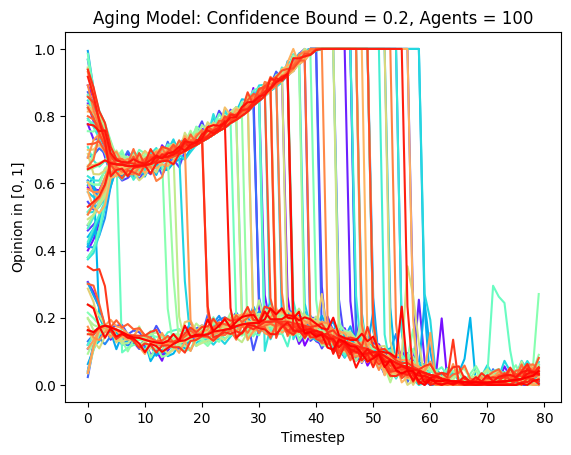

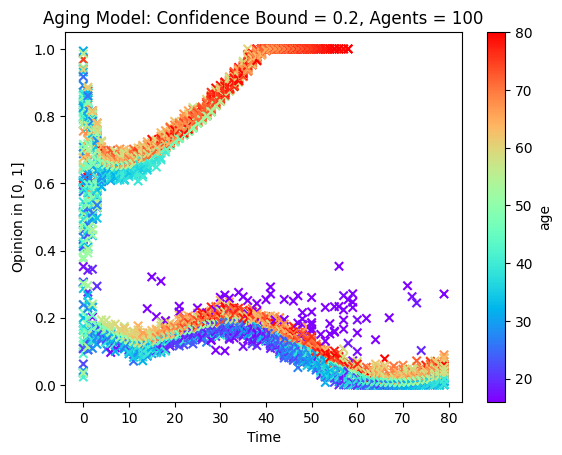

In [20]:
#plotting

colours = plt.cm.rainbow(np.linspace(0,1,num_of_agents))

for i in range(num_of_agents):
    plt.plot(opinions_over_time[:,i],color=colours[i])
plt.title(f'Aging Model: Confidence Bound = {R}, Agents = {num_of_agents}')
plt.xlabel('Timestep')
plt.ylabel('Opinion in $[0,1]$')
plt.show()

#plotting

colours = plt.cm.rainbow(np.linspace(0,1,round(max_age-min_age+1)))
sp = plt.scatter(np.array([range(Timesteps)]*num_of_agents).T, opinions_over_time, c=ages_over_time, cmap='rainbow', marker='x')
plt.colorbar(sp, label="age")
plt.title(f'Aging Model: Confidence Bound = {R}, Agents = {num_of_agents}')
plt.xlabel('Time')
plt.ylabel('Opinion in $[0,1]$')
plt.show()